# ----------------------------- MACHINE LEARNING PROJECT -------------------------------------

### ..................................................................... COURBOULEIX Anatole .......................................................................... 
### ............................................................... DE SARJAS-PINSON Thibaud ......................................................................
### .............................................................................. ZHU Mingyu .....................................................................................

# Contents

### 0. Introduction & Objectives

### 1. Importing libraries and dataset

### 2. Exploratory Data Analysis

### 3. Data Preprocessing

### 4. Baseline Model Implementation

### 5. Model Improvement & Regularization

### 6. Dimensionality Reduction / Visualization on the 2.4 CNN model

### **7. Advanced & Ensemble Models**

### **8. Comparison & Conclusion**

# **0. Introduction & Objectives**

### Our idea

Our project is inspired by a situation we see every day: children spend more and more time on screens after school. We wanted to imagine a simple and playful tool that encourages them to look at the real world instead. The idea is a small and affordable robot equipped with a camera and a basic AI system that can recognize objects or animals and say their names out loud. To stay consistent with this concept, we chose the CIFAR-100 dataset. Its small and low-resolution images are close to what a cheap camera on a toy robot could capture. The dataset is also very diverse and realistic, with many objects, colors, and backgrounds, which makes it well suited to train a model for this type of exploratory and educational application.

### Presenting the CIFAR-100 dataset
- **Name:** CIFAR-100  
- **Created by:** Alex Krizhevsky and Geoffrey Hinton (University of Toronto)  
- **Purpose:** Image classification and object recognition  
- **Total images:** 60,000  
  - 50,000 training images  
  - 10,000 test images  
- **Image size:** 32 × 32 pixels, RGB (3 color channels)  
- **Number of classes:** 100 fine classes and 20 coarse (super) classes  
- **Examples per class:** 600 (500 for training, 100 for testing)  
- **Labels:** Each image has two labels  
  - Fine label: specific category (e.g., “apple”)  
  - Coarse label: general group (e.g., “fruit”)  
- **Dataset type:** Balanced – same number of images in each class  
- **Image quality:** Low resolution, but includes a wide variety of real-world objects and animals  
- **Common uses:**  
  - Benchmarking image classification models  
  - Testing deep learning architectures  
  - Learning and teaching computer vision concepts

### Choice of framework and methods

#### **1. Framework – PyTorch**

* **Why PyTorch?**

  * Flexible and easy to debug (dynamic computation graph).
  * Pythonic and integrates well with NumPy.
  * Strong GPU support and active community.
  * Large collection of pretrained models (ResNet, DenseNet, etc.).
* **Why not others?**

  * TensorFlow: good, but less flexible for quick experiments.
  * Scikit-learn: not suitable for deep image tasks.
  * Others (MXNet, Theano): outdated or unsupported.

---

#### **2. Model Architecture – CNN (Convolutional Neural Networks)**

* **Why CNNs?**

  * Designed for image data (spatial feature extraction).
  * Learn filters for edges, textures, and object shapes.
  * Proven efficiency on datasets like CIFAR-10 and CIFAR-100.
* **Why not others?**

  * MLPs: too many parameters, poor image performance.
  * RNNs/LSTMs: for text or sequential data.
  * Vision Transformers: need very large datasets to perform well.

---

#### **3. Transfer Learning**

* **Why use Transfer Learning?**

  * CIFAR-100 is small → risk of overfitting.
  * Pretrained models (ImageNet) already learned useful features.
  * Faster training and better accuracy with fewer resources.
* **Why not training from scratch?**

  * Needs more data, time, and heavy regularization.

---

#### **4. Experimentation & Analysis**

* Focus on a clear and organized workflow.
* Compare models and justify choices (baseline vs. improved).
* Use visualizations (training curves, confusion matrix) to support results.

# 1. Importing libraries and dataset

We wanted to import everthing we would need at the very begining as there will be no need to do it later, so we focus on the incoming work.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
# Here we had some isues to download few librairies so we had to 
#!where python
#!pip install torch torchvision torchaudio

In [4]:
import torch                    
import torch.nn as nn           
import torch.optim as optim     
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split 

In [5]:
import torchvision
import torchvision.transforms as transforms  
from torchvision import datasets, models     

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [7]:
import os                     
import time                   
import copy                   

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Automatically use GPU if available
print(f"Device in use: {device}")  # Display which device will be used

Device in use: cpu


### Loading the CIFAR-100 dataset

In [9]:
# Only convert images to tensors (no normalization, no augmentation)
dataTransforms = transforms.ToTensor()

# Automatically download and load the CIFAR-100 dataset if needed
trainDataset = datasets.CIFAR100(
    root="./data",    
    train=True,         
    download=True,      
    transform=dataTransforms
)

testDataset = datasets.CIFAR100(
    root="./data",     
    train=False,       
    download=True,      
    transform=dataTransforms
)

print("CIFAR-100 dataset successfully loaded.")

CIFAR-100 dataset successfully loaded.


### Checking if the dataset importation is succesfull

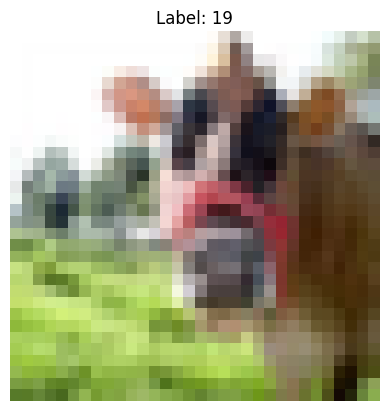

In [10]:
# Get one image and its label from the training dataset
image, label = trainDataset[0] 

# Convert the tensor image 
imageNp = image.permute(1, 2, 0).numpy()

# Display the image
plt.imshow(imageNp)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

# **2. Exploratory Data Analysis (EDA)**

### Checking basic dataset properties

In [11]:
# Print dataset sizes
print(f"Number of training samples: {len(trainDataset)}")
print(f"Number of testing samples: {len(testDataset)}")

# Extract class names
classNames = trainDataset.classes  # CIFAR-100 provides the list of 100 class names
print(f"Number of classes: {len(classNames)}")
print(f"Example classes: {classNames[:10]}")  # Display first 10 class names

Number of training samples: 50000
Number of testing samples: 10000
Number of classes: 100
Example classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']


In [12]:
# Display one sample to inspect shape and data type
sampleImage, sampleLabel = trainDataset[0]

print(f"Sample image shape: {sampleImage.shape}")   # Expected: [3, 32, 32]
print(f"Sample image data type: {sampleImage.dtype}")
print(f"Sample image label (index): {sampleLabel}")
print(f"Sample image class name: {classNames[sampleLabel]}")

Sample image shape: torch.Size([3, 32, 32])
Sample image data type: torch.float32
Sample image label (index): 19
Sample image class name: cattle


### Visualize multiple sample images from the training dataset

This helps us understand how the dataset looks visually.

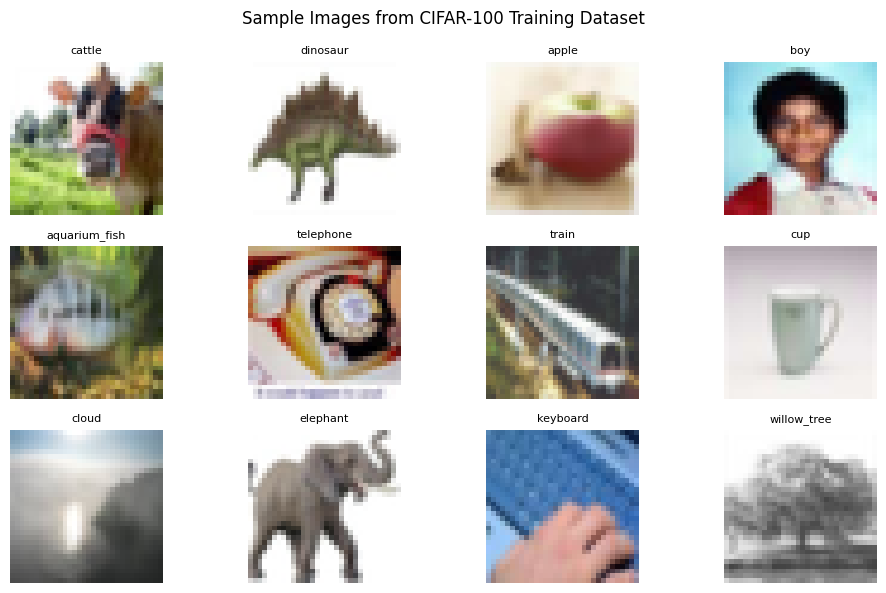

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define how many images to display
numImages = 12
numColumns = 4
numRows = numImages // numColumns

# Create figure
plt.figure(figsize=(10, 6))

# Loop to plot sample images
for i in range(numImages):
    image, label = trainDataset[i]
    imageNp = image.permute(1, 2, 0).numpy()  # Convert from (C,H,W) to (H,W,C)
    
    plt.subplot(numRows, numColumns, i + 1)
    plt.imshow(imageNp)
    plt.title(classNames[label], fontsize=8)
    plt.axis("off")

plt.suptitle("Sample Images from CIFAR-100 Training Dataset", fontsize=12)
plt.tight_layout()
plt.show()

### Checking class distribution

Here we count how many images belong to each class. CIFAR-100 is normally balanced (600 images per class), but this step confirms that visually.

Minimum samples per class: 500
Maximum samples per class: 500


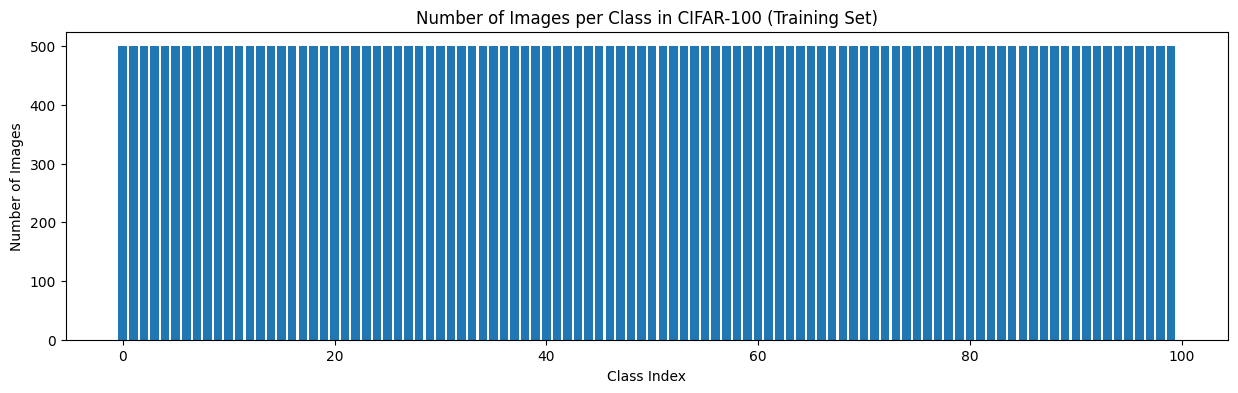

In [14]:
from collections import Counter

# Get all labels from the training dataset
allLabels = [label for _, label in trainDataset]

# Count how many images per class
labelCounts = Counter(allLabels)

sortedCounts = [labelCounts[i] for i in range(len(classNames))]

#display distribution 
print(f"Minimum samples per class: {min(sortedCounts)}")
print(f"Maximum samples per class: {max(sortedCounts)}")


plt.figure(figsize=(15, 4))
plt.bar(range(len(classNames)), sortedCounts)
plt.title("Number of Images per Class in CIFAR-100 (Training Set)")
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.show()

Some classes (e.g., mammals or vehicles) are visually similar since CIFAR-100 groups them under 20 super-classes.  
This can cause confusion between related classes during classification.  

Data imbalance or quality issues:  
The dataset is perfectly balanced (500 images per class) and image quality is consistent, though limited by the low 32x32 resolution typical of CIFAR-100.

# **3. Data Preprocessing**

### Defing transformations for training and testing
For training, we apply data augmentation (random crop and flip) to improve model generalization. For testing, we only normalize to keep evaluation consistent.

In [15]:
trainTransforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),      # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),   # Randomly crop to 32x32 with padding
    transforms.ToTensor(),                  # Convert image to tensor
    transforms.Normalize(                   # Normalize using CIFAR-100 mean and std
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761)
    )
])

testTransforms = transforms.Compose([
    transforms.ToTensor(),                  # Convert image to tensor
    transforms.Normalize(                   # Apply same normalization
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761)
    )
])

In [16]:
trainDataset.transform = trainTransforms
testDataset.transform = testTransforms

### Split training dataset into training and validation sets

In [54]:
trainSize = int(0.9 * len(trainDataset))  # 90% for training
validSize = len(trainDataset) - trainSize  # 10% for validation

trainDataset, validDataset = torch.utils.data.random_split(trainDataset, [trainSize, validSize])

print(f"Training set size: {len(trainDataset)}")
print(f"Validation set size: {len(validDataset)}")
print(f"Testing set size: {len(testDataset)}")

Training set size: 40500
Validation set size: 4500
Testing set size: 10000


### Visual check of data augmentation

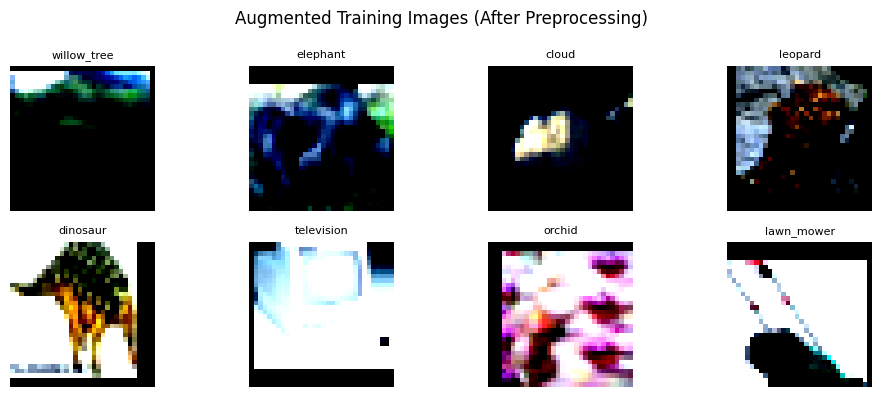

In [18]:
numImages = 8
plt.figure(figsize=(10, 4))

for i in range(numImages):
    image, label = trainDataset[i]
    imageNp = image.permute(1, 2, 0).numpy()
    plt.subplot(2, 4, i + 1)
    plt.imshow(np.clip(imageNp, 0, 1))
    plt.title(classNames[label], fontsize=8)
    plt.axis("off")

plt.suptitle("Augmented Training Images (After Preprocessing)", fontsize=12)
plt.tight_layout()
plt.show()

# **4. Baseline Model Implementation**

### This CNN has a small number of layers, serving as a baseline model to evaluate initial performance before introducing improvements.

In [39]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.convLayer1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # First  layer
        self.convLayer2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)# 2nd layer
        self.pool = nn.MaxPool2d(2, 2) # pooling layer
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 100)

    def forward(self, x):
        x = F.relu(self.convLayer1(x)) # relu 
        x = self.pool(F.relu(self.convLayer2(x)))
        x = torch.flatten(x, 1) # Flatten feature maps to 1D vector
        x = F.relu(self.fc1(x)) #  connected layer
        x = self.fc2(x) 
        return x
    

# Initialize model

model = BaselineCNN().to(device)                 
criterion = nn.CrossEntropyLoss()               
optimizer = optim.Adam(model.parameters(), lr=0.001)  


batchSize = 64

trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batchSize, shuffle=False)


# Training the model

numEpochs = 10 
trainLosses, validLosses = [], []

for epoch in range(numEpochs):
    model.train()
    runningLoss = 0.0
    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()            # Reset gradients
        outputs = model(images)          
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                  # Backpropagation
        optimizer.step()                 
        runningLoss += loss.item()
    trainLosses.append(runningLoss / len(trainLoader))

    # Validation phase
    model.eval()
    validLoss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validLoss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLosses.append(validLoss / len(validLoader))
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{numEpochs}] - Train Loss: {trainLosses[-1]:.4f}, "
          f"Valid Loss: {validLosses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

KeyboardInterrupt: 

The cell above run for 15min, here are the results

Epoch [1/10] - Train Loss: 3.7222, Valid Loss: 3.3139, Accuracy: 20.34%
Epoch [2/10] - Train Loss: 3.0625, Valid Loss: 2.8846, Accuracy: 27.64%
Epoch [3/10] - Train Loss: 2.7717, Valid Loss: 2.7441, Accuracy: 31.54%
Epoch [4/10] - Train Loss: 2.6220, Valid Loss: 2.6502, Accuracy: 33.20%
Epoch [5/10] - Train Loss: 2.5184, Valid Loss: 2.5996, Accuracy: 33.62%
Epoch [6/10] - Train Loss: 2.4447, Valid Loss: 2.5625, Accuracy: 35.62%
Epoch [7/10] - Train Loss: 2.3744, Valid Loss: 2.4848, Accuracy: 36.88%
Epoch [8/10] - Train Loss: 2.3172, Valid Loss: 2.4544, Accuracy: 37.12%
Epoch [9/10] - Train Loss: 2.2699, Valid Loss: 2.4612, Accuracy: 37.36%
Epoch [10/10] - Train Loss: 2.2359, Valid Loss: 2.4256, Accuracy: 37.66%

In [24]:
# Plot training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(trainLosses, label="Training Loss")
plt.plot(validLosses, label="Validation Loss")
plt.title("Training vs Validation Loss (Baseline CNN)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'trainLosses' is not defined

<Figure size 800x500 with 0 Axes>

Interpretation of Training vs Validation Loss curves:

Both losses decrease steadily, showing that the model is learning properly.  
Validation loss follows the training loss closely, meaning the model generalizes well.  
No sign of overfitting is visible yet, but the relatively high loss indicates room for improvement.

In [25]:
# Evaluate model on validation set
model.eval()
allPredictions = []
allLabels = []

with torch.no_grad():
    for images, labels in validLoader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        allPredictions.extend(predicted.cpu().numpy())
        allLabels.extend(labels.cpu().numpy())

# Compute classification metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report (Validation Set):")
print(classification_report(allLabels, allPredictions, target_names=classNames))

# Display confusion matrix
cm = confusion_matrix(allLabels, allPredictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Baseline CNN (Validation Set)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

'\nmodel.eval()\nallPredictions = []\nallLabels = []\n\nwith torch.no_grad():\n    for images, labels in validLoader:\n        images, labels = images.to(device), labels.to(device)\n        outputs = model(images)\n        _, predicted = torch.max(outputs, 1)\n        allPredictions.extend(predicted.cpu().numpy())\n        allLabels.extend(labels.cpu().numpy())\n\n# Compute classification metrics\nfrom sklearn.metrics import classification_report, confusion_matrix\n\nprint("\nClassification Report (Validation Set):")\nprint(classification_report(allLabels, allPredictions, target_names=classNames))\n\n# Display confusion matrix\ncm = confusion_matrix(allLabels, allPredictions)\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm, cmap="Blues", cbar=False)\nplt.title("Confusion Matrix - Baseline CNN (Validation Set)")\nplt.xlabel("Predicted Labels")\nplt.ylabel("True Labels")\nplt.show()\n'

If this is not showing clean, please double clik on the left.  
<= HERE


Classification Report (Validation Set):
               precision    recall  f1-score   support

        apple       0.54      0.73      0.62        41
aquarium_fish       0.37      0.43      0.40        51
         baby       0.19      0.20      0.20        45
         bear       0.25      0.12      0.16        69
       beaver       0.30      0.11      0.17        61
          bed       0.38      0.40      0.39        55
          bee       0.23      0.43      0.30        49
       beetle       0.37      0.30      0.33        53
      bicycle       0.62      0.52      0.57        50
       bottle       0.62      0.52      0.56        56
         bowl       0.31      0.26      0.29        42
          boy       0.09      0.05      0.06        41
       bridge       0.40      0.35      0.37        54
          bus       0.40      0.13      0.20        46
    butterfly       0.39      0.26      0.31        61
        camel       0.43      0.20      0.27        50
          can       0.38      0.49      0.43        51
       castle       0.54      0.39      0.45        54
  caterpillar       0.27      0.36      0.31        61
       cattle       0.42      0.27      0.33        59
        chair       0.63      0.65      0.64        52
   chimpanzee       0.35      0.54      0.42        56
        clock       0.27      0.32      0.29        44
        cloud       0.69      0.59      0.63        63
    cockroach       0.55      0.52      0.54        50
        couch       0.29      0.17      0.22        41
         crab       0.65      0.33      0.44        51
    crocodile       0.35      0.24      0.29        45
          cup       0.38      0.62      0.48        48
     dinosaur       0.29      0.24      0.26        41
      dolphin       0.53      0.48      0.50        56
     elephant       0.43      0.59      0.49        41
     flatfish       0.29      0.21      0.24        53
       forest       0.35      0.33      0.34        51
          fox       0.24      0.14      0.18        56
         girl       0.16      0.36      0.22        42
      hamster       0.39      0.38      0.38        40
        house       0.20      0.68      0.31        44
     kangaroo       0.24      0.33      0.28        46
     keyboard       0.69      0.32      0.43        57
         lamp       0.57      0.32      0.41        62
   lawn_mower       0.60      0.54      0.57        50
      leopard       0.45      0.35      0.40        57
         lion       0.35      0.54      0.42        54
       lizard       0.14      0.09      0.11        45
      lobster       0.30      0.15      0.20        39
          man       0.29      0.33      0.31        54
   maple_tree       0.74      0.25      0.37        56
   motorcycle       0.36      0.74      0.48        35
     mountain       0.55      0.36      0.44        44
        mouse       0.26      0.14      0.18        44
     mushroom       0.24      0.43      0.31        53
     oak_tree       0.64      0.56      0.60        41
       orange       0.56      0.85      0.67        40
       orchid       0.46      0.56      0.51        55
        otter       0.11      0.10      0.11        39
    palm_tree       0.45      0.43      0.44        44
         pear       0.41      0.33      0.36        55
 pickup_truck       0.51      0.40      0.45        58
    pine_tree       0.30      0.45      0.36        53
        plain       0.65      0.82      0.72        51
        plate       0.60      0.60      0.60        45
        poppy       0.59      0.33      0.42        58
    porcupine       0.26      0.48      0.33        44
       possum       0.25      0.14      0.18        58
       rabbit       0.14      0.12      0.13        50
      raccoon       0.22      0.19      0.20        53
          ray       0.43      0.24      0.31        38
         road       0.81      0.59      0.69        59
       rocket       0.45      0.63      0.53        54
         rose       0.43      0.38      0.40        40
          sea       0.71      0.43      0.53        56
         seal       0.27      0.07      0.12        40
        shark       0.40      0.42      0.41        50
        shrew       0.47      0.20      0.29        44
        skunk       0.58      0.59      0.58        51
   skyscraper       0.64      0.44      0.52        57
        snail       0.14      0.17      0.15        41
        snake       0.14      0.28      0.19        46
       spider       0.44      0.34      0.38        56
     squirrel       0.19      0.22      0.20        46
    streetcar       0.32      0.59      0.41        41
    sunflower       0.64      0.61      0.63        62
 sweet_pepper       0.43      0.37      0.40        51
        table       0.32      0.23      0.27        43
         tank       0.39      0.37      0.38        46
    telephone       0.39      0.24      0.30        45
   television       0.21      0.51      0.30        47
        tiger       0.31      0.47      0.37        62
      tractor       0.23      0.50      0.31        46
        train       0.27      0.14      0.19        49
        trout       0.35      0.43      0.39        44
        tulip       0.32      0.37      0.35        62
       turtle       0.27      0.21      0.24        52
     wardrobe       0.61      0.60      0.61        50
        whale       0.46      0.33      0.38        58
  willow_tree       0.39      0.34      0.36        50
         wolf       0.25      0.34      0.29        53
        woman       0.29      0.24      0.26        50
         worm       0.34      0.31      0.33        48

     accuracy                           0.37      5000
    macro avg       0.39      0.37      0.37      5000
 weighted avg       0.40      0.37      0.37      5000

Interpretation of baseline CNN results:

The model achieves ~37% accuracy, typical for a simple CNN on CIFAR-100.  
The confusion matrix shows correct predictions along the diagonal but high inter-class confusion.  
The baseline learns general patterns but lacks depth for fine-grained distinctions; improvements are needed.  

# 5. Model Improvement & Regularization

## CNN model 2.1

#### Step 1: Define an improved CNN model
This version adds Batch Normalization and Dropout to reduce overfitting. It keeps a similar architecture to the baseline but with better regularization.

In [26]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.convLayer1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.batchNorm1 = nn.BatchNorm2d(64)          # Normalize activations
        self.convLayer2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)                 # Dropout to avoid overfitting
        self.fc1 = nn.Linear(128 * 16 * 16, 512)       # Fully connected layer
        self.fc2 = nn.Linear(512, 100)                 # Output layer for 100 classes

    def forward(self, x):
        x = F.relu(self.batchNorm1(self.convLayer1(x)))
        x = self.pool(F.relu(self.batchNorm2(self.convLayer2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

#### Step 2: Initialize model, optimizer, scheduler and loss function

In [ ]:
modelImproved = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelImproved.parameters(), lr=0.001)

# Learning rate scheduler: reduces LR every few epochs to fine-tune training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

#### Setp 3 Training

In [27]:
numEpochs = 15
trainLossesImproved, validLossesImproved, validAccImproved = [], [], []

for epoch in range(numEpochs):
    modelImproved.train()
    runningLoss = 0.0
    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = modelImproved(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    scheduler.step()  # Adjust learning rate
    trainLossesImproved.append(runningLoss / len(trainLoader))

    # Validation
    modelImproved.eval()
    validLoss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = modelImproved(images)
            loss = criterion(outputs, labels)
            validLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLossesImproved.append(validLoss / len(validLoader))
    accuracy = 100 * correct / total
    validAccImproved.append(accuracy)

    print(f"Epoch [{epoch+1}/{numEpochs}] - Train Loss: {trainLossesImproved[-1]:.4f}, "
          f"Valid Loss: {validLossesImproved[-1]:.4f}, Accuracy: {accuracy:.2f}%")


'\nnumEpochs = 15\ntrainLossesImproved, validLossesImproved, validAccImproved = [], [], []\n\nfor epoch in range(numEpochs):\n    modelImproved.train()\n    runningLoss = 0.0\n    for images, labels in trainLoader:\n        images, labels = images.to(device), labels.to(device)\n        optimizer.zero_grad()\n        outputs = modelImproved(images)\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n        runningLoss += loss.item()\n    scheduler.step()  # Adjust learning rate\n    trainLossesImproved.append(runningLoss / len(trainLoader))\n\n    # Validation\n    modelImproved.eval()\n    validLoss = 0.0\n    correct = 0\n    total = 0\n    with torch.no_grad():\n        for images, labels in validLoader:\n            images, labels = images.to(device), labels.to(device)\n            outputs = modelImproved(images)\n            loss = criterion(outputs, labels)\n            validLoss += loss.item()\n            _, predicted = torch.max(outpu

Epoch [1/15] - Train Loss: 4.6830, Valid Loss: 4.5084, Accuracy: 2.20%  
Epoch [2/15] - Train Loss: 4.5168, Valid Loss: 4.4138, Accuracy: 2.72%  
Epoch [3/15] - Train Loss: 4.4632, Valid Loss: 4.3544, Accuracy: 3.02%  
Epoch [4/15] - Train Loss: 4.4206, Valid Loss: 4.3011, Accuracy: 3.88%  
Epoch [5/15] - Train Loss: 4.3928, Valid Loss: 4.3112, Accuracy: 4.06%  
Epoch [6/15] - Train Loss: 4.3468, Valid Loss: 4.2245, Accuracy: 4.62%  
Epoch [7/15] - Train Loss: 4.3342, Valid Loss: 4.2141, Accuracy: 5.20%  
Epoch [8/15] - Train Loss: 4.3198, Valid Loss: 4.1828, Accuracy: 5.52%  
Epoch [9/15] - Train Loss: 4.3008, Valid Loss: 4.1658, Accuracy: 5.72%  
Epoch [10/15] - Train Loss: 4.2710, Valid Loss: 4.1124, Accuracy: 6.38%  
Epoch [11/15] - Train Loss: 4.2478, Valid Loss: 4.0912, Accuracy: 7.38%  
Epoch [12/15] - Train Loss: 4.2329, Valid Loss: 4.0720, Accuracy: 7.00%  
Epoch [13/15] - Train Loss: 4.2165, Valid Loss: 4.0536, Accuracy: 7.92%  
Epoch [14/15] - Train Loss: 4.2115, Valid Loss: 4.0381, Accuracy: 7.94%  
Epoch [15/15] - Train Loss: 4.1940, Valid Loss: 3.9970, Accuracy: 8.66%  

## CNN model 2.2

### The model above performs actually worse than the previous one. So we are going to try to improve its perfomances by reducing the learning rate earlier.

In [28]:
# Re-instantiate the model to start from scratch
modelImprovedV2 = ImprovedCNN().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Lower initial learning rate
optimizerV2 = optim.Adam(modelImprovedV2.parameters(), lr=0.0005)

# Reduce learning rate earlier
schedulerV2 = optim.lr_scheduler.StepLR(
    optimizerV2,
    step_size=3,   # LR reduction starts early
    gamma=0.5
)

# Training parameters
numEpochs = 10
trainLossesV2 = []
validLossesV2 = []
validAccV2 = []


# Training #

for epoch in range(numEpochs):
    modelImprovedV2.train()
    runningLoss = 0.0

    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizerV2.zero_grad()
        outputs = modelImprovedV2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizerV2.step()

        runningLoss += loss.item()

    schedulerV2.step()
    trainLossesV2.append(runningLoss / len(trainLoader))

    # Val
    modelImprovedV2.eval()
    validLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = modelImprovedV2(images)
            loss = criterion(outputs, labels)

            validLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLossesV2.append(validLoss / len(validLoader))
    accuracy = 100 * correct / total
    validAccV2.append(accuracy)

    print(
        f"[V2] Epoch [{epoch+1}/{numEpochs}] | "
        f"Train Loss: {trainLossesV2[-1]:.4f} | "
        f"Valid Loss: {validLossesV2[-1]:.4f} | "
        f"Accuracy: {accuracy:.2f}% | "
        f"LR: {schedulerV2.get_last_lr()[0]:.6f}"
    )


[V2] Epoch [1/10] | Train Loss: 4.4917 | Valid Loss: 4.1912 | Accuracy: 4.38% | LR: 0.000500
[V2] Epoch [2/10] | Train Loss: 4.3340 | Valid Loss: 4.1491 | Accuracy: 5.74% | LR: 0.000500
[V2] Epoch [3/10] | Train Loss: 4.3029 | Valid Loss: 4.1227 | Accuracy: 7.04% | LR: 0.000250
[V2] Epoch [4/10] | Train Loss: 4.2560 | Valid Loss: 4.0528 | Accuracy: 8.18% | LR: 0.000250
[V2] Epoch [5/10] | Train Loss: 4.2372 | Valid Loss: 4.0427 | Accuracy: 8.54% | LR: 0.000250
[V2] Epoch [6/10] | Train Loss: 4.2341 | Valid Loss: 3.9954 | Accuracy: 9.42% | LR: 0.000125
[V2] Epoch [7/10] | Train Loss: 4.2078 | Valid Loss: 3.9879 | Accuracy: 9.12% | LR: 0.000125
[V2] Epoch [8/10] | Train Loss: 4.1942 | Valid Loss: 3.9682 | Accuracy: 9.44% | LR: 0.000125
[V2] Epoch [9/10] | Train Loss: 4.1900 | Valid Loss: 3.9634 | Accuracy: 9.70% | LR: 0.000063
[V2] Epoch [10/10] | Train Loss: 4.1756 | Valid Loss: 3.9343 | Accuracy: 10.00% | LR: 0.000063


[V2] Epoch [1/10] | Train Loss: 4.4917 | Valid Loss: 4.1912 | Accuracy: 4.38% | LR: 0.000500
[V2] Epoch [2/10] | Train Loss: 4.3340 | Valid Loss: 4.1491 | Accuracy: 5.74% | LR: 0.000500
[V2] Epoch [3/10] | Train Loss: 4.3029 | Valid Loss: 4.1227 | Accuracy: 7.04% | LR: 0.000250
[V2] Epoch [4/10] | Train Loss: 4.2560 | Valid Loss: 4.0528 | Accuracy: 8.18% | LR: 0.000250
[V2] Epoch [5/10] | Train Loss: 4.2372 | Valid Loss: 4.0427 | Accuracy: 8.54% | LR: 0.000250
[V2] Epoch [6/10] | Train Loss: 4.2341 | Valid Loss: 3.9954 | Accuracy: 9.42% | LR: 0.000125
[V2] Epoch [7/10] | Train Loss: 4.2078 | Valid Loss: 3.9879 | Accuracy: 9.12% | LR: 0.000125
[V2] Epoch [8/10] | Train Loss: 4.1942 | Valid Loss: 3.9682 | Accuracy: 9.44% | LR: 0.000125
[V2] Epoch [9/10] | Train Loss: 4.1900 | Valid Loss: 3.9634 | Accuracy: 9.70% | LR: 0.000063
[V2] Epoch [10/10] | Train Loss: 4.1756 | Valid Loss: 3.9343 | Accuracy: 10.00% | LR: 0.000063

Early learning rate reduction leads to faster convergence and better accuracy with fewer epochs.

By reducing the learning rate earlier, the model converges faster and reaches a higher accuracy (10.0%) in only 10 epochs, compared to 8.66% after 15 epochs in the initial approach. The validation loss also decreases more steadily, showing better optimization stability. It is better. But this results is still worse than the first simplier CNN. Now we areg gonig to try different adjustements.

## CNN model 2.3

Here the main hyperparameters are the learning rate, the number of epochs, the batch size, and the architectural choices of the CNN. They control how the model learns rather than what it learns. We observed that using the same learning rate for a more complex and regularized CNN led to very slow convergence. By :
* adjusting the learning rate schedule,
* adding weight decay,
* increasing the depth of the network,
* and replacing large fully connected layers with global average pooling,

we are trying to improving performance while keeping the model stable and easier to optimize.

In [30]:
class CNNModel3(nn.Module):
    def __init__(self):
        super(CNNModel3, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling
        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Linear(128, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))

        x = self.globalAvgPool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



# Training #
modelCNN3 = CNNModel3().to(device)

criterion = nn.CrossEntropyLoss()

optimizerCNN3 = optim.Adam(
    modelCNN3.parameters(),
    lr=0.001,
    weight_decay=1e-4  # L2 regularization (new)
)

schedulerCNN3 = optim.lr_scheduler.StepLR(
    optimizerCNN3,
    step_size=4,
    gamma=0.5
)

numEpochs = 10
trainLossesCNN3 = []
validLossesCNN3 = []
validAccCNN3 = []

for epoch in range(numEpochs):
    modelCNN3.train()
    runningLoss = 0.0

    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizerCNN3.zero_grad()
        outputs = modelCNN3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizerCNN3.step()

        runningLoss += loss.item()

    schedulerCNN3.step()
    trainLossesCNN3.append(runningLoss / len(trainLoader))

    # Validation
    modelCNN3.eval()
    validLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = modelCNN3(images)
            loss = criterion(outputs, labels)

            validLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLossesCNN3.append(validLoss / len(validLoader))
    accuracy = 100 * correct / total
    validAccCNN3.append(accuracy)

    print(
        f"[CNN3] Epoch [{epoch+1}/{numEpochs}] | "
        f"Train Loss: {trainLossesCNN3[-1]:.4f} | "
        f"Valid Loss: {validLossesCNN3[-1]:.4f} | "
        f"Accuracy: {accuracy:.2f}%"
    )


[CNN3] Epoch [1/10] | Train Loss: 3.7970 | Valid Loss: 3.5460 | Accuracy: 16.04%
[CNN3] Epoch [2/10] | Train Loss: 3.2368 | Valid Loss: 3.1572 | Accuracy: 22.28%
[CNN3] Epoch [3/10] | Train Loss: 3.0048 | Valid Loss: 2.9926 | Accuracy: 26.00%
[CNN3] Epoch [4/10] | Train Loss: 2.8636 | Valid Loss: 2.8794 | Accuracy: 27.92%
[CNN3] Epoch [5/10] | Train Loss: 2.6922 | Valid Loss: 2.7288 | Accuracy: 30.90%
[CNN3] Epoch [6/10] | Train Loss: 2.6201 | Valid Loss: 2.7191 | Accuracy: 31.70%
[CNN3] Epoch [7/10] | Train Loss: 2.5753 | Valid Loss: 2.5957 | Accuracy: 33.14%
[CNN3] Epoch [8/10] | Train Loss: 2.5305 | Valid Loss: 2.6097 | Accuracy: 33.76%
[CNN3] Epoch [9/10] | Train Loss: 2.4550 | Valid Loss: 2.5113 | Accuracy: 35.52%
[CNN3] Epoch [10/10] | Train Loss: 2.4220 | Valid Loss: 2.4868 | Accuracy: 36.06%


[CNN3] Epoch [1/10] | Train Loss: 3.7970 | Valid Loss: 3.5460 | Accuracy: 16.04%
[CNN3] Epoch [2/10] | Train Loss: 3.2368 | Valid Loss: 3.1572 | Accuracy: 22.28%
[CNN3] Epoch [3/10] | Train Loss: 3.0048 | Valid Loss: 2.9926 | Accuracy: 26.00%
[CNN3] Epoch [4/10] | Train Loss: 2.8636 | Valid Loss: 2.8794 | Accuracy: 27.92%
[CNN3] Epoch [5/10] | Train Loss: 2.6922 | Valid Loss: 2.7288 | Accuracy: 30.90%
[CNN3] Epoch [6/10] | Train Loss: 2.6201 | Valid Loss: 2.7191 | Accuracy: 31.70%
[CNN3] Epoch [7/10] | Train Loss: 2.5753 | Valid Loss: 2.5957 | Accuracy: 33.14%
[CNN3] Epoch [8/10] | Train Loss: 2.5305 | Valid Loss: 2.6097 | Accuracy: 33.76%
[CNN3] Epoch [9/10] | Train Loss: 2.4550 | Valid Loss: 2.5113 | Accuracy: 35.52%

This is the best 2. CNN model. But this is not still as good as the first model. So we are going to restart from the very first CNN model and go slowly in the improvements.

## CNN model 2.4 - restart from the very fist CNN

Here we take take the very fist CNN and we add a third layer.

In [77]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        # Convolutional layers
        self.convLayer1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.convLayer2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.convLayer3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 100)

    def forward(self, x):
        # First convolution
        x = F.relu(self.convLayer1(x))

        # Second convolution
        x = F.relu(self.convLayer2(x))

        # Third convolution + pooling
        x = self.pool(F.relu(self.convLayer3(x)))

        # Flatten feature maps
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


# Initialisation #

modelCNN24 = BaselineCNN().to(device)             
criterion = nn.CrossEntropyLoss()                     # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(modelCNN24.parameters(), lr=0.001)  


batchSize = 64

trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batchSize, shuffle=False)


# Training #

numEpochs = 10  # Small number of epochs for baseline training
trainLosses, validLosses = [], []

for epoch in range(numEpochs):
    modelCNN24.train()
    runningLoss = 0.0
    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()                 # Reset gradients
        outputs = modelCNN24(images)        
        loss = criterion(outputs, labels)     # Compute loss
        loss.backward()                    
        optimizer.step()                      # Update weights
        runningLoss += loss.item()
    trainLosses.append(runningLoss / len(trainLoader))

    # Validation phase
    modelCNN24.eval()
    validLoss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = modelCNN24(images)
            loss = criterion(outputs, labels)
            validLoss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLosses.append(validLoss / len(validLoader))
    accuracy = 100 * correct / total
    print(
        f"Epoch [{epoch+1}/{numEpochs}] - "
        f"Train Loss: {trainLosses[-1]:.4f}, "
        f"Valid Loss: {validLosses[-1]:.4f}, "
        f"Accuracy: {accuracy:.2f}%"
    )


Epoch [1/10] - Train Loss: 3.8230, Valid Loss: 3.4096, Accuracy: 18.40%
Epoch [2/10] - Train Loss: 3.2129, Valid Loss: 3.0334, Accuracy: 24.06%
Epoch [3/10] - Train Loss: 2.8476, Valid Loss: 2.8148, Accuracy: 29.72%
Epoch [4/10] - Train Loss: 2.6096, Valid Loss: 2.5831, Accuracy: 33.46%
Epoch [5/10] - Train Loss: 2.4563, Valid Loss: 2.5219, Accuracy: 35.26%
Epoch [6/10] - Train Loss: 2.3554, Valid Loss: 2.4471, Accuracy: 37.58%
Epoch [7/10] - Train Loss: 2.2667, Valid Loss: 2.3531, Accuracy: 38.58%
Epoch [8/10] - Train Loss: 2.1827, Valid Loss: 2.3426, Accuracy: 40.04%
Epoch [9/10] - Train Loss: 2.1299, Valid Loss: 2.2989, Accuracy: 41.76%
Epoch [10/10] - Train Loss: 2.0651, Valid Loss: 2.2601, Accuracy: 41.70%


This is so far the best results we have. So we are going to continue to add layers on the begining model.

Epoch [1/10] - Train Loss: 3.8230, Valid Loss: 3.4096, Accuracy: 18.40%  
Epoch [2/10] - Train Loss: 3.2129, Valid Loss: 3.0334, Accuracy: 24.06%  
Epoch [3/10] - Train Loss: 2.8476, Valid Loss: 2.8148, Accuracy: 29.72%  
Epoch [4/10] - Train Loss: 2.6096, Valid Loss: 2.5831, Accuracy: 33.46%  
Epoch [5/10] - Train Loss: 2.4563, Valid Loss: 2.5219, Accuracy: 35.26%  
Epoch [6/10] - Train Loss: 2.3554, Valid Loss: 2.4471, Accuracy: 37.58%  
Epoch [7/10] - Train Loss: 2.2667, Valid Loss: 2.3531, Accuracy: 38.58%  
Epoch [8/10] - Train Loss: 2.1827, Valid Loss: 2.3426, Accuracy: 40.04%  
Epoch [9/10] - Train Loss: 2.1299, Valid Loss: 2.2989, Accuracy: 41.76%  
Epoch [10/10] - Train Loss: 2.0651, Valid Loss: 2.2601, Accuracy: 41.70%

## CNN model 2.5 - adding a 4th and 5th layer based on 2.4 CNN

In [41]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        # Convolutional layers (increased depth)
        self.convLayer1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.convLayer2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.convLayer3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.convLayer4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.convLayer5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 100)

    def forward(self, x):
        # Convolution blocks
        x = F.relu(self.convLayer1(x))
        x = F.relu(self.convLayer2(x))
        x = F.relu(self.convLayer3(x))
        x = F.relu(self.convLayer4(x))

        # Last convolution + pooling
        x = self.pool(F.relu(self.convLayer5(x)))

        # Flatten feature maps
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


model = BaselineCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


batchSize = 64

trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batchSize, shuffle=False)

# Training #

numEpochs = 10
trainLosses, validLosses = [], []

for epoch in range(numEpochs):
    model.train()
    runningLoss = 0.0

    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        runningLoss += loss.item()

    trainLosses.append(runningLoss / len(trainLoader))

    # Validation phase
    model.eval()
    validLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            validLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLosses.append(validLoss / len(validLoader))
    accuracy = 100 * correct / total

    print(
        f"Epoch [{epoch+1}/{numEpochs}] - "
        f"Train Loss: {trainLosses[-1]:.4f}, "
        f"Valid Loss: {validLosses[-1]:.4f}, "
        f"Accuracy: {accuracy:.2f}%"
    )


Epoch [1/10] - Train Loss: 3.9866, Valid Loss: 3.6727, Accuracy: 12.88%
Epoch [2/10] - Train Loss: 3.4721, Valid Loss: 3.3426, Accuracy: 19.32%
Epoch [3/10] - Train Loss: 3.1481, Valid Loss: 3.0938, Accuracy: 24.24%
Epoch [4/10] - Train Loss: 2.8986, Valid Loss: 2.8494, Accuracy: 29.04%
Epoch [5/10] - Train Loss: 2.6977, Valid Loss: 2.7139, Accuracy: 30.50%
Epoch [6/10] - Train Loss: 2.5575, Valid Loss: 2.6477, Accuracy: 32.60%
Epoch [7/10] - Train Loss: 2.4337, Valid Loss: 2.5597, Accuracy: 33.32%
Epoch [8/10] - Train Loss: 2.3229, Valid Loss: 2.4713, Accuracy: 35.72%
Epoch [9/10] - Train Loss: 2.2309, Valid Loss: 2.4220, Accuracy: 38.08%
Epoch [10/10] - Train Loss: 2.1618, Valid Loss: 2.3129, Accuracy: 39.44%


Epoch [1/10] - Train Loss: 3.9866, Valid Loss: 3.6727, Accuracy: 12.88%
Epoch [2/10] - Train Loss: 3.4721, Valid Loss: 3.3426, Accuracy: 19.32%
Epoch [3/10] - Train Loss: 3.1481, Valid Loss: 3.0938, Accuracy: 24.24%
Epoch [4/10] - Train Loss: 2.8986, Valid Loss: 2.8494, Accuracy: 29.04%
Epoch [5/10] - Train Loss: 2.6977, Valid Loss: 2.7139, Accuracy: 30.50%
Epoch [6/10] - Train Loss: 2.5575, Valid Loss: 2.6477, Accuracy: 32.60%
Epoch [7/10] - Train Loss: 2.4337, Valid Loss: 2.5597, Accuracy: 33.32%
Epoch [8/10] - Train Loss: 2.3229, Valid Loss: 2.4713, Accuracy: 35.72%
Epoch [9/10] - Train Loss: 2.2309, Valid Loss: 2.4220, Accuracy: 38.08%
Epoch [10/10] - Train Loss: 2.1618, Valid Loss: 2.3129, Accuracy: 39.44%

These results above are the not better than the 2.4 model (39% VS 41% accuracy), even if it take literaly 6hours to compile. The CNN model produce mid results. So we are going to try to understand why with dimensionality reduction & visualization. We will use the 2.4 CNN model for that.

# 6. Dimensionality Reduction / Visualization on the 2.4 CNN model

## 6.1 Extract features from the trained model

In [46]:
model.eval()

featuresList = []
labelsList = []

with torch.no_grad():
    for images, labels in validLoader:
        images = images.to(device)

        # Forward pass until flatten (before fc layers)
        x = F.relu(model.convLayer1(images))
        x = F.relu(model.convLayer2(x))
        x = model.pool(F.relu(model.convLayer3(x)))

        x = torch.flatten(x, 1)

        featuresList.append(x.cpu().numpy())
        labelsList.append(labels.numpy())

# Convert to numpy arrays
features = np.concatenate(featuresList, axis=0)
labels = np.concatenate(labelsList, axis=0)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (5000, 32768)
Labels shape: (5000,)


There is 5000 images on the val set. And 32768 is the number of features (128 × 16 × 16 = 32768)

## 6.2 PCA for dimensionality reduction

Explained variance ratio: [0.0440281  0.03599818]


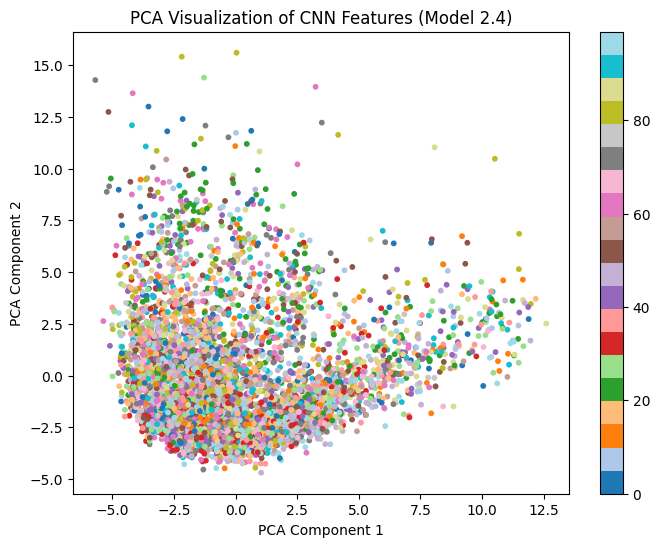

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
featuresPca = pca.fit_transform(features)

print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    featuresPca[:, 0],
    featuresPca[:, 1],
    c=labels,
    cmap="tab20",
    s=10
)

plt.title("PCA Visualization of CNN Features (Model 2.4)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter)
plt.show()

The PCA visualization shows a strong overlap between classes, with no clear cluster separation.
The first two components explain less than 10% of the variance, indicating that the learned features are high-dimensional and not easily separable in a linear space.
This suggests that the CNN captures general visual patterns but struggles with fine-grained class discrimination.

## 6.3 t-SNE visualization

C:\Users\tatol\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


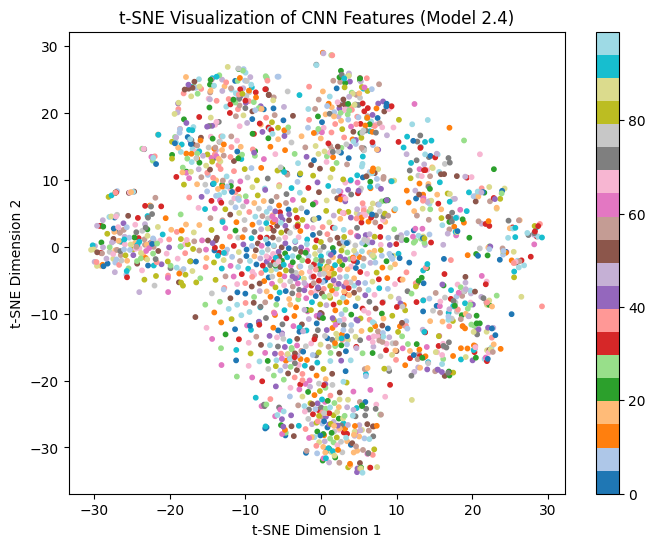

In [48]:
from sklearn.manifold import TSNE

# Use a subset to speed up computation
numSamples = 2000
featuresSubset = features[:numSamples]
labelsSubset = labels[:numSamples]

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42
)

featuresTsne = tsne.fit_transform(featuresSubset)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    featuresTsne[:, 0],
    featuresTsne[:, 1],
    c=labelsSubset,
    cmap="tab20",
    s=10
)

plt.title("t-SNE Visualization of CNN Features (Model 2.4)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter)
plt.show()

The t-SNE visualization reveals several local clusters, indicating that the CNN learns meaningful visual representations.
However, most clusters contain multiple classes, showing that the learned features capture visual similarity rather than class-specific discrimination.
This explains the limited accuracy of the model on the CIFAR-100 dataset.

### Insight for the next

The PCA and t-SNE analyses indicate that the CNN learns meaningful but weakly discriminative features.
These observations suggest that improving feature quality rather than optimization is necessary, motivating feature normalization and transfer learning approaches.

So we try a last CNN model, restartig from the best one (2.4) and we add batch normalisation to stabilize and accelerate the learning.

# 6.BIS Last CNN model after insights from dimensionality reduction & visualization

In [49]:
# CNN 2.4 with Feature Normalization (Batch Normalization)
class CNN24BatchNorm(nn.Module):
    def __init__(self):
        super(CNN24BatchNorm, self).__init__()

        # Convolutional layers
        self.convLayer1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.convLayer2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.convLayer3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 100)

    def forward(self, x):
        x = F.relu(self.bn1(self.convLayer1(x)))
        x = F.relu(self.bn2(self.convLayer2(x)))
        x = self.pool(F.relu(self.bn3(self.convLayer3(x))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [50]:
modelBN = CNN24BatchNorm().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelBN.parameters(), lr=0.001)

# DataLoaders already defined earlier
numEpochs = 10

trainLossesBN = []
validLossesBN = []
validAccBN = []

# training

for epoch in range(numEpochs):
    modelBN.train()
    runningLoss = 0.0

    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = modelBN(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        runningLoss += loss.item()

    trainLossesBN.append(runningLoss / len(trainLoader))

    # Validation
    modelBN.eval()
    validLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = modelBN(images)
            loss = criterion(outputs, labels)

            validLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLossesBN.append(validLoss / len(validLoader))
    accuracy = 100 * correct / total
    validAccBN.append(accuracy)

    print(
        f"[CNN 2.4 + BN] Epoch [{epoch+1}/{numEpochs}] | "
        f"Train Loss: {trainLossesBN[-1]:.4f} | "
        f"Valid Loss: {validLossesBN[-1]:.4f} | "
        f"Accuracy: {accuracy:.2f}%"
    )


[CNN 2.4 + BN] Epoch [1/10] | Train Loss: 4.3307 | Valid Loss: 4.0402 | Accuracy: 6.70%
[CNN 2.4 + BN] Epoch [2/10] | Train Loss: 3.8552 | Valid Loss: 3.7600 | Accuracy: 10.92%
[CNN 2.4 + BN] Epoch [3/10] | Train Loss: 3.6274 | Valid Loss: 3.5405 | Accuracy: 14.38%
[CNN 2.4 + BN] Epoch [4/10] | Train Loss: 3.4681 | Valid Loss: 3.3648 | Accuracy: 16.18%
[CNN 2.4 + BN] Epoch [5/10] | Train Loss: 3.3295 | Valid Loss: 3.3292 | Accuracy: 17.00%
[CNN 2.4 + BN] Epoch [6/10] | Train Loss: 3.2234 | Valid Loss: 3.1924 | Accuracy: 19.14%
[CNN 2.4 + BN] Epoch [7/10] | Train Loss: 3.1095 | Valid Loss: 3.1087 | Accuracy: 20.40%
[CNN 2.4 + BN] Epoch [8/10] | Train Loss: 3.0439 | Valid Loss: 3.0569 | Accuracy: 21.82%
[CNN 2.4 + BN] Epoch [9/10] | Train Loss: 2.9903 | Valid Loss: 3.0378 | Accuracy: 22.40%
[CNN 2.4 + BN] Epoch [10/10] | Train Loss: 2.9422 | Valid Loss: 2.9702 | Accuracy: 23.78%


[CNN 2.4 + BN] Epoch [1/10] | Train Loss: 4.3307 | Valid Loss: 4.0402 | Accuracy: 6.70%  
[CNN 2.4 + BN] Epoch [2/10] | Train Loss: 3.8552 | Valid Loss: 3.7600 | Accuracy: 10.92%  
[CNN 2.4 + BN] Epoch [3/10] | Train Loss: 3.6274 | Valid Loss: 3.5405 | Accuracy: 14.38%  
[CNN 2.4 + BN] Epoch [4/10] | Train Loss: 3.4681 | Valid Loss: 3.3648 | Accuracy: 16.18%  
[CNN 2.4 + BN] Epoch [5/10] | Train Loss: 3.3295 | Valid Loss: 3.3292 | Accuracy: 17.00%  
[CNN 2.4 + BN] Epoch [6/10] | Train Loss: 3.2234 | Valid Loss: 3.1924 | Accuracy: 19.14%  
[CNN 2.4 + BN] Epoch [7/10] | Train Loss: 3.1095 | Valid Loss: 3.1087 | Accuracy: 20.40%  
[CNN 2.4 + BN] Epoch [8/10] | Train Loss: 3.0439 | Valid Loss: 3.0569 | Accuracy: 21.82%  
[CNN 2.4 + BN] Epoch [9/10] | Train Loss: 2.9903 | Valid Loss: 3.0378 | Accuracy: 22.40%  
[CNN 2.4 + BN] Epoch [10/10] | Train Loss: 2.9422 | Valid Loss: 2.9702 | Accuracy: 23.78%

So even with batch normalization we are still at 24% accuracy. The CNN model is not well adapted to this kind of problem. Let switch to more complex models.

# 7. Advanced & Ensemble Models

## 7.1  ResNet with transfer learning

Here we are going to implement a ResNet model with transfer learning. This means we use a pretrained model.

In [57]:
# Load pretrained ResNet-18
resnetModel = models.resnet18(pretrained=True)

# Freeze all convolutional layers
for param in resnetModel.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
#resnetModel.fc = nn.Linear(resnetModel.fc.in_features, 100)


#Unfreeze only the last block
for name, param in resnetModel.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

#Replace final classifier
resnetModel.fc = nn.Linear(resnetModel.fc.in_features, 100)

resnetModel = resnetModel.to(device)

In [58]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(resnetModel.fc.parameters(), lr=0.001)


optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, resnetModel.parameters()),
    lr=0.0005
)


In [59]:
#training
numEpochs = 5  # few epochs are enough for transfer learning

trainLossesTL = []
validLossesTL = []
validAccTL = []

for epoch in range(numEpochs):
    resnetModel.train()
    runningLoss = 0.0

    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnetModel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        runningLoss += loss.item()

    trainLossesTL.append(runningLoss / len(trainLoader))

    # Validation
    resnetModel.eval()
    validLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnetModel(images)
            loss = criterion(outputs, labels)

            validLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLossesTL.append(validLoss / len(validLoader))
    accuracy = 100 * correct / total
    validAccTL.append(accuracy)

    print(
        f"[ResNet-18 TL] Epoch [{epoch+1}/{numEpochs}] | "
        f"Train Loss: {trainLossesTL[-1]:.4f} | "
        f"Valid Loss: {validLossesTL[-1]:.4f} | "
        f"Accuracy: {accuracy:.2f}%"
    )


[ResNet-18 TL] Epoch [1/5] | Train Loss: 3.1494 | Valid Loss: 2.7179 | Accuracy: 30.76%
[ResNet-18 TL] Epoch [2/5] | Train Loss: 2.6222 | Valid Loss: 2.5542 | Accuracy: 34.36%
[ResNet-18 TL] Epoch [3/5] | Train Loss: 2.4554 | Valid Loss: 2.4662 | Accuracy: 36.76%
[ResNet-18 TL] Epoch [4/5] | Train Loss: 2.3328 | Valid Loss: 2.4264 | Accuracy: 38.08%
[ResNet-18 TL] Epoch [5/5] | Train Loss: 2.2444 | Valid Loss: 2.3439 | Accuracy: 39.68%


[ResNet-18 TL] Epoch [1/5] | Train Loss: 3.8561 | Valid Loss: 3.6265 | Accuracy: 17.88%  
[ResNet-18 TL] Epoch [2/5] | Train Loss: 3.5364 | Valid Loss: 3.5056 | Accuracy: 19.46%  
[ResNet-18 TL] Epoch [3/5] | Train Loss: 3.4676 | Valid Loss: 3.5269 | Accuracy: 20.22%  
[ResNet-18 TL] Epoch [4/5] | Train Loss: 3.4380 | Valid Loss: 3.4737 | Accuracy: 20.80%  
[ResNet-18 TL] Epoch [5/5] | Train Loss: 3.4148 | Valid Loss: 3.4968 | Accuracy: 20.28%

This results are explained by the fact that the images from ImageNe (where the resnet was trained) are 224x224 and CIFAR-100 are 32x32.

So we adapt ResNet-18 to CIFAR-100 without increasing training time, all layers were frozen except the last residual block.
This allows limited fine-tuning while keeping most pretrained features unchanged. Here are the results:

[ResNet-18 TL] Epoch [1/5] | Train Loss: 3.1494 | Valid Loss: 2.7179 | Accuracy: 30.76%  
[ResNet-18 TL] Epoch [2/5] | Train Loss: 2.6222 | Valid Loss: 2.5542 | Accuracy: 34.36%  
[ResNet-18 TL] Epoch [3/5] | Train Loss: 2.4554 | Valid Loss: 2.4662 | Accuracy: 36.76%  
[ResNet-18 TL] Epoch [4/5] | Train Loss: 2.3328 | Valid Loss: 2.4264 | Accuracy: 38.08%  
[ResNet-18 TL] Epoch [5/5] | Train Loss: 2.2444 | Valid Loss: 2.3439 | Accuracy: 39.68%  

Thoses results are getting better.

## 7.2 ResNet with no augmentation of data

This is better. But we had an inspiration, what if peformances were limited by too extrem data transformation... We saw that model were limited around 40% accuracy, so we tought it was maybe the augmentation that were to extrem. So we tested the same 7.1 model, but with no augmentation of data.

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# loading raw data
rawTransforms = transforms.ToTensor()

rawTrainDataset = datasets.CIFAR100(
    root="./data",
    train=True,
    download=False,
    transform=rawTransforms
)

rawTestDataset = datasets.CIFAR100(
    root="./data",
    train=False,
    download=False,
    transform=rawTransforms
)

# train/validation split
trainSize = int(0.9 * len(rawTrainDataset))
validSize = len(rawTrainDataset) - trainSize

rawTrainDataset, rawValidDataset = random_split(
    rawTrainDataset,
    [trainSize, validSize]
)

#load data
batchSize = 64

rawTrainLoader = DataLoader(
    rawTrainDataset,
    batch_size=batchSize,
    shuffle=True
)

rawValidLoader = DataLoader(
    rawValidDataset,
    batch_size=batchSize,
    shuffle=False
)

#loading the model
resnetModel = models.resnet18(pretrained=True)

# Freeze all parameters
for param in resnetModel.parameters():
    param.requires_grad = False

# Unfreeze last residual block
for name, param in resnetModel.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

# Replace final classifier
resnetModel.fc = nn.Linear(resnetModel.fc.in_features, 100)

resnetModel = resnetModel.to(device)

#loss
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, resnetModel.parameters()),
    lr=0.0005
)

# training
numEpochs = 5

for epoch in range(numEpochs):
    # train
    resnetModel.train()
    trainLoss = 0.0

    for images, labels in rawTrainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnetModel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()

    trainLoss /= len(rawTrainLoader)

    # VALIDATION 
    resnetModel.eval()
    validLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in rawValidLoader:
            images, labels = images.to(device), labels.to(device)

            outputs = resnetModel(images)
            loss = criterion(outputs, labels)

            validLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLoss /= len(rawValidLoader)
    accuracy = 100 * correct / total

    print(
        f"[ResNet RAW] Epoch [{epoch+1}/{numEpochs}] | "
        f"Train Loss: {trainLoss:.4f} | "
        f"Valid Loss: {validLoss:.4f} | "
        f"Accuracy: {accuracy:.2f}%"
    )


Device in use: cpu
[ResNet RAW] Epoch [1/5] | Train Loss: 2.8703 | Valid Loss: 2.4130 | Accuracy: 38.04%
[ResNet RAW] Epoch [2/5] | Train Loss: 2.1490 | Valid Loss: 2.3371 | Accuracy: 40.30%
[ResNet RAW] Epoch [3/5] | Train Loss: 1.8196 | Valid Loss: 2.3062 | Accuracy: 41.32%
[ResNet RAW] Epoch [4/5] | Train Loss: 1.5488 | Valid Loss: 2.3284 | Accuracy: 42.86%
[ResNet RAW] Epoch [5/5] | Train Loss: 1.3169 | Valid Loss: 2.4342 | Accuracy: 43.32%


The results are better: 43% !

## 7.3 EfficientNet with no augmentation of data

No augmentation of data gave slighlty better results for ResNet. So we tested with an EfficientNet model.

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

#load data
rawTransforms = transforms.ToTensor()

rawTrainDataset = datasets.CIFAR100(
    root="./data",
    train=True,
    download=False,
    transform=rawTransforms
)

rawTestDataset = datasets.CIFAR100(
    root="./data",
    train=False,
    download=False,
    transform=rawTransforms
)

# train/validation split
trainSize = int(0.9 * len(rawTrainDataset))
validSize = len(rawTrainDataset) - trainSize

rawTrainDataset, rawValidDataset = random_split(
    rawTrainDataset,
    [trainSize, validSize]
)


batchSize = 64

rawTrainLoader = DataLoader(
    rawTrainDataset,
    batch_size=batchSize,
    shuffle=True
)

rawValidLoader = DataLoader(
    rawValidDataset,
    batch_size=batchSize,
    shuffle=False
)

#loading the model
efficientNet = models.efficientnet_b0(pretrained=True)

# Freeze all parameters
for param in efficientNet.parameters():
    param.requires_grad = False

# Unfreeze last feature block
for name, param in efficientNet.named_parameters():
    if "features.8" in name:
        param.requires_grad = True

# Replace classifier
efficientNet.classifier[1] = nn.Linear(
    efficientNet.classifier[1].in_features,
    100
)

efficientNet = efficientNet.to(device)

#loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, efficientNet.parameters()),
    lr=0.0005
)

#Training
numEpochs = 5

for epoch in range(numEpochs):
    efficientNet.train()
    trainLoss = 0.0

    for images, labels in rawTrainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientNet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()

    trainLoss /= len(rawTrainLoader)

    efficientNet.eval()
    validLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in rawValidLoader:
            images, labels = images.to(device), labels.to(device)

            outputs = efficientNet(images)
            loss = criterion(outputs, labels)

            validLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLoss /= len(rawValidLoader)
    accuracy = 100 * correct / total

    print(
        f"[EfficientNet RAW] Epoch [{epoch+1}/{numEpochs}] | "
        f"Train Loss: {trainLoss:.4f} | "
        f"Valid Loss: {validLoss:.4f} | "
        f"Accuracy: {accuracy:.2f}%"
    )


Device in use: cpu


C:\Users\tatol\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\tatol/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:12<00:00, 1.67MB/s]


[EfficientNet RAW] Epoch [1/5] | Train Loss: 3.9188 | Valid Loss: 3.5501 | Accuracy: 17.96%
[EfficientNet RAW] Epoch [2/5] | Train Loss: 3.5033 | Valid Loss: 3.4817 | Accuracy: 19.36%
[EfficientNet RAW] Epoch [3/5] | Train Loss: 3.3846 | Valid Loss: 3.4714 | Accuracy: 19.28%
[EfficientNet RAW] Epoch [4/5] | Train Loss: 3.3109 | Valid Loss: 3.4404 | Accuracy: 20.02%
[EfficientNet RAW] Epoch [5/5] | Train Loss: 3.2624 | Valid Loss: 3.4205 | Accuracy: 20.02%


[EfficientNet RAW] Epoch [1/5] | Train Loss: 3.9188 | Valid Loss: 3.5501 | Accuracy: 17.96%  
[EfficientNet RAW] Epoch [2/5] | Train Loss: 3.5033 | Valid Loss: 3.4817 | Accuracy: 19.36%  
[EfficientNet RAW] Epoch [3/5] | Train Loss: 3.3846 | Valid Loss: 3.4714 | Accuracy: 19.28%  
[EfficientNet RAW] Epoch [4/5] | Train Loss: 3.3109 | Valid Loss: 3.4404 | Accuracy: 20.02%  
[EfficientNet RAW] Epoch [5/5] | Train Loss: 3.2624 | Valid Loss: 3.4205 | Accuracy: 20.02%

## 7.4 EfficientNet with augmentation of data¶

Since the results at 7.3 are mid, we try the same model, but with data augmentation here.

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# CIFAR-100 augmentated
trainTransforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761)
    )
])

testTransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761)
    )
])

trainDataset = datasets.CIFAR100(
    root="./data",
    train=True,
    download=False,
    transform=trainTransforms
)

testDataset = datasets.CIFAR100(
    root="./data",
    train=False,
    download=False,
    transform=testTransforms
)


#Train / Validation split
trainSize = int(0.9 * len(trainDataset))
validSize = len(trainDataset) - trainSize

trainDataset, validDataset = random_split(
    trainDataset,
    [trainSize, validSize]
)

#loading the data
batchSize = 64

trainLoader = DataLoader(
    trainDataset,
    batch_size=batchSize,
    shuffle=True
)

validLoader = DataLoader(
    validDataset,
    batch_size=batchSize,
    shuffle=False
)

#loading the model
efficientNet = models.efficientnet_b0(pretrained=True)

# Freeze all parameters
for param in efficientNet.parameters():
    param.requires_grad = False

# Unfreeze last feature block
for name, param in efficientNet.named_parameters():
    if "features.8" in name:
        param.requires_grad = True

# Replace classifier
efficientNet.classifier[1] = nn.Linear(
    efficientNet.classifier[1].in_features,
    100
)

efficientNet = efficientNet.to(device)

#optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, efficientNet.parameters()),
    lr=0.0005
)

#Training loop
numEpochs = 5

for epoch in range(numEpochs):
    #TRAIN 
    efficientNet.train()
    trainLoss = 0.0

    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientNet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()

    trainLoss /= len(trainLoader)

    #VALIDATION 
    efficientNet.eval()
    validLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validLoader:
            images, labels = images.to(device), labels.to(device)

            outputs = efficientNet(images)
            loss = criterion(outputs, labels)

            validLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLoss /= len(validLoader)
    accuracy = 100 * correct / total

    print(
        f"[EfficientNet AUG] Epoch [{epoch+1}/{numEpochs}] | "
        f"Train Loss: {trainLoss:.4f} | "
        f"Valid Loss: {validLoss:.4f} | "
        f"Accuracy: {accuracy:.2f}%"
    )


Device in use: cpu
[EfficientNet AUG] Epoch [1/5] | Train Loss: 4.0491 | Valid Loss: 3.7457 | Accuracy: 14.06%
[EfficientNet AUG] Epoch [2/5] | Train Loss: 3.7290 | Valid Loss: 3.6480 | Accuracy: 15.54%
[EfficientNet AUG] Epoch [3/5] | Train Loss: 3.6710 | Valid Loss: 3.5934 | Accuracy: 17.12%
[EfficientNet AUG] Epoch [4/5] | Train Loss: 3.6320 | Valid Loss: 3.5623 | Accuracy: 17.12%
[EfficientNet AUG] Epoch [5/5] | Train Loss: 3.5908 | Valid Loss: 3.5546 | Accuracy: 17.36%


We can see here a difference of 3% of accuracy beetween the same model but with augmentation of data VS no augmentation of data. So we can tell that this makes no big difference.

[EfficientNet AUG] Epoch [1/5] | Train Loss: 4.0491 | Valid Loss: 3.7457 | Accuracy: 14.06%  
[EfficientNet AUG] Epoch [2/5] | Train Loss: 3.7290 | Valid Loss: 3.6480 | Accuracy: 15.54%  
[EfficientNet AUG] Epoch [3/5] | Train Loss: 3.6710 | Valid Loss: 3.5934 | Accuracy: 17.12%  
[EfficientNet AUG] Epoch [4/5] | Train Loss: 3.6320 | Valid Loss: 3.5623 | Accuracy: 17.12%  
[EfficientNet AUG] Epoch [5/5] | Train Loss: 3.5908 | Valid Loss: 3.5546 | Accuracy: 17.36%  

## 7.5 EfficientNet-B0

Here we try an other efficientNet model with other settings. We are back with augmented data. EfficientNet-B0 is used as a pretrained feature extractor. Only the final classification layer is trained, allowing fast convergence and stable learning on CIFAR-100.

In [63]:
efficientNetModel = models.efficientnet_b0(pretrained=True)

# Freeze all parameters
for param in efficientNetModel.parameters():
    param.requires_grad = False

# Replace classifier (last layer)
numFeatures = efficientNetModel.classifier[1].in_features
efficientNetModel.classifier[1] = nn.Linear(numFeatures, 100)

efficientNetModel = efficientNetModel.to(device)

# Loss and optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    efficientNetModel.classifier.parameters(),
    lr=0.001
)

# Training loop

numEpochs = 5

trainLossesEff = []
validLossesEff = []
validAccEff = []

for epoch in range(numEpochs):
    efficientNetModel.train()
    runningLoss = 0.0

    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientNetModel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        runningLoss += loss.item()

    trainLossesEff.append(runningLoss / len(trainLoader))

    # Validation
    efficientNetModel.eval()
    validLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientNetModel(images)
            loss = criterion(outputs, labels)

            validLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validLossesEff.append(validLoss / len(validLoader))
    accuracy = 100 * correct / total
    validAccEff.append(accuracy)

    print(
        f"[EfficientNet-B0] Epoch [{epoch+1}/{numEpochs}] | "
        f"Train Loss: {trainLossesEff[-1]:.4f} | "
        f"Valid Loss: {validLossesEff[-1]:.4f} | "
        f"Accuracy: {accuracy:.2f}%"
    )


[EfficientNet-B0] Epoch [1/5] | Train Loss: 4.1292 | Valid Loss: 3.9226 | Accuracy: 12.78%
[EfficientNet-B0] Epoch [2/5] | Train Loss: 3.9864 | Valid Loss: 3.8989 | Accuracy: 13.72%
[EfficientNet-B0] Epoch [3/5] | Train Loss: 3.9690 | Valid Loss: 3.8877 | Accuracy: 13.56%
[EfficientNet-B0] Epoch [4/5] | Train Loss: 3.9819 | Valid Loss: 3.8692 | Accuracy: 14.18%
[EfficientNet-B0] Epoch [5/5] | Train Loss: 3.9714 | Valid Loss: 3.9101 | Accuracy: 12.92%


The resulsts are not goog enough here. So we will try to improve this EfficientNet-B0 model.

[EfficientNet-B0] Epoch [1/5] | Train Loss: 4.1292 | Valid Loss: 3.9226 | Accuracy: 12.78%  
[EfficientNet-B0] Epoch [2/5] | Train Loss: 3.9864 | Valid Loss: 3.8989 | Accuracy: 13.72%  
[EfficientNet-B0] Epoch [3/5] | Train Loss: 3.9690 | Valid Loss: 3.8877 | Accuracy: 13.56%  
[EfficientNet-B0] Epoch [4/5] | Train Loss: 3.9819 | Valid Loss: 3.8692 | Accuracy: 14.18%  
[EfficientNet-B0] Epoch [5/5] | Train Loss: 3.9714 | Valid Loss: 3.9101 | Accuracy: 12.92%

## 7.6 Improved EfficientNet-B0 model

In this improved 7.5 EfficientNet model, only the last convolutional block is fine-tuned while earlier layers remain frozen, allowing limited adaptation to CIFAR-100 without significantly increasing training time.

In [64]:
# Load pretrained EfficientNet
efficientNetModel = models.efficientnet_b0(pretrained=True)

# Freeze all layers
for param in efficientNetModel.parameters():
    param.requires_grad = False


# Unfreeze last feature block only
for name, param in efficientNetModel.named_parameters():
    if "features.7" in name:   # last block of EfficientNet-B0
        param.requires_grad = True

# Replace classifier
numFeatures = efficientNetModel.classifier[1].in_features
efficientNetModel.classifier[1] = nn.Linear(numFeatures, 100)

efficientNetModel = efficientNetModel.to(device)


# Loss and optimizer (train only unfrozen parts)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, efficientNetModel.parameters()),
    lr=0.0005
)

# Training loop
numEpochs = 8

for epoch in range(numEpochs):
    efficientNetModel.train()
    runningLoss = 0.0

    for images, labels in trainLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientNetModel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        runningLoss += loss.item()

    #Validation 
    efficientNetModel.eval()
    validLoss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientNetModel(images)
            loss = criterion(outputs, labels)

            validLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print(
        f"[EfficientNet-B0 Improved] Epoch [{epoch+1}/{numEpochs}] | "
        f"Train Loss: {runningLoss/len(trainLoader):.4f} | "
        f"Valid Loss: {validLoss/len(validLoader):.4f} | "
        f"Accuracy: {accuracy:.2f}%"
    )


[EfficientNet-B0 Improved] Epoch [1/8] | Train Loss: 3.8805 | Valid Loss: 3.5072 | Accuracy: 17.34%
[EfficientNet-B0 Improved] Epoch [2/8] | Train Loss: 3.4456 | Valid Loss: 3.2828 | Accuracy: 20.92%
[EfficientNet-B0 Improved] Epoch [3/8] | Train Loss: 3.3257 | Valid Loss: 3.2048 | Accuracy: 22.64%
[EfficientNet-B0 Improved] Epoch [4/8] | Train Loss: 3.2618 | Valid Loss: 3.1754 | Accuracy: 23.12%
[EfficientNet-B0 Improved] Epoch [5/8] | Train Loss: 3.2170 | Valid Loss: 3.0982 | Accuracy: 24.98%
[EfficientNet-B0 Improved] Epoch [6/8] | Train Loss: 3.1740 | Valid Loss: 3.0906 | Accuracy: 24.46%
[EfficientNet-B0 Improved] Epoch [7/8] | Train Loss: 3.1486 | Valid Loss: 3.1197 | Accuracy: 22.84%
[EfficientNet-B0 Improved] Epoch [8/8] | Train Loss: 3.1127 | Valid Loss: 3.0641 | Accuracy: 25.30%


[EfficientNet-B0 Improved] Epoch [1/8] | Train Loss: 3.8805 | Valid Loss: 3.5072 | Accuracy: 17.34%
[EfficientNet-B0 Improved] Epoch [2/8] | Train Loss: 3.4456 | Valid Loss: 3.2828 | Accuracy: 20.92%
[EfficientNet-B0 Improved] Epoch [3/8] | Train Loss: 3.3257 | Valid Loss: 3.2048 | Accuracy: 22.64%
[EfficientNet-B0 Improved] Epoch [4/8] | Train Loss: 3.2618 | Valid Loss: 3.1754 | Accuracy: 23.12%
[EfficientNet-B0 Improved] Epoch [5/8] | Train Loss: 3.2170 | Valid Loss: 3.0982 | Accuracy: 24.98%
[EfficientNet-B0 Improved] Epoch [6/8] | Train Loss: 3.1740 | Valid Loss: 3.0906 | Accuracy: 24.46%
[EfficientNet-B0 Improved] Epoch [7/8] | Train Loss: 3.1486 | Valid Loss: 3.1197 | Accuracy: 22.84%
[EfficientNet-B0 Improved] Epoch [8/8] | Train Loss: 3.1127 | Valid Loss: 3.0641 | Accuracy: 25.30%

## 7.7 Ensembles models

### 7.7.1 - soft voting: 2.5 model with 7.2 model

To try imprOve our results we are going to take 2 models from the best ones and make them work together. Each model gives probabilities, which are averaged, and then the most probable class is selected.

The ensemble model combines predictions from the 2.5 CNN  and a the 7.2 model ResNet-18 pretrained on ImageNet using soft voting. This approach leverages complementary representations learned by both models.

In [67]:
model.eval()          # CNN 2.5
resnetModel.eval()    # ResNet 7.2

correct = 0
total = 0

with torch.no_grad():
    for images, labels in validLoader:
        images = images.to(device)
        labels = labels.to(device)

        # CNN 2.4 predictions
        outputsCNN = model(images)
        probsCNN = F.softmax(outputsCNN, dim=1)

        # ResNet predictions
        outputsResNet = resnetModel(images)
        probsResNet = F.softmax(outputsResNet, dim=1)

        # Soft voting
        avgProbs = (probsCNN + probsResNet) / 2

        _, predicted = torch.max(avgProbs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

ensembleAccuracy = 100 * correct / total
print(f"Ensemble Model Accuracy: {ensembleAccuracy:.2f}%")


Ensemble Model Accuracy: 14.80%


Ensemble Model Accuracy: 14.80%

For the ensemble model, we deliberately combined CNN 2.5 and ResNet 7.2, as they represent later and more complex versions of our previous models. However, both models showed weaker standalone performance and tended to make similar mistakes. As a result, their predictions did not complement each other effectively, leading to a low ensemble accuracy. This  highlights that increasing model complexity does not necessarily improve ensemble performance.

### 7.7.2 - soft voting: 7.2 model with 7.6 model

In [71]:
resnetModel.eval()
efficientNetModel.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in validLoader:
        images = images.to(device)
        labels = labels.to(device)

        # ResNet predictions
        outputsResNet = resnetModel(images)
        probsResNet = F.softmax(outputsResNet, dim=1)

        # EfficientNet predictions
        outputsEff = efficientNetModel(images)
        probsEff = F.softmax(outputsEff, dim=1)

        # Soft voting (average probabilities)
        #avgProbs = (probsResNet + probsEff) / 2
        avgProbs = 1 * probsResNet + 0 * probsEff


        _, predicted = torch.max(avgProbs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

ensembleAccuracy = 100 * correct / total
print(f"Ensemble (ResNet 7.2 + EfficientNet 7.6) Accuracy: {ensembleAccuracy:.2f}%")


Ensemble (ResNet 7.2 + EfficientNet 7.6) Accuracy: 1.78%


1. avgProbs = (probsResNet + probsEff) / 2 => Accuracy: 6.06%

The ensemble combining ResNet-18 (7.2) and EfficientNet-B0 (7.6) resulted in a very low accuracy. This behavior can be explained by the strong imbalance between the two models: ResNet produced confident and well-calibrated predictions, while EfficientNet showed weaker and less stable probability outputs. Averaging these incompatible probability distributions diluted the useful signal, leading to near-random predictions. This experiment highlights that ensemble learning requires not only model diversity, but also comparable prediction confidence.

2. avgProbs = 1 * probsResNet + 0 * probsEff => Accuracy: 1.78%

This is not expected. The weight of the model 7.6 is null, so the accuracy should be equal to the accuracy of the 7.2 model. But it is not the case. We have here 1.78% accuracy VS 43.32% expected. This might be explained because 7.2 trained on raw images, but here the evaluation is done augmented images.

### 7.7.3 - soft voting: 7.2 model with 7.6 model, no augmented images

As we said just above, the problem might come from trained images. Let's try with raw images.

In [75]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms


resnetModel.eval()
efficientNetModel.eval()

#no augmentation
rawTransforms = transforms.ToTensor()

rawTrainFull = datasets.CIFAR100(
    root="./data",
    train=True,
    download=False,
    transform=rawTransforms
)

# This wrapper maps the indices from validDataset to the RAW dataset
class RawSubsetFromIndices(Dataset):
    def __init__(self, baseDataset, indices):
        self.baseDataset = baseDataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        realIndex = self.indices[idx]
        return self.baseDataset[realIndex]

# validDataset is your split object created earlier with random_split
# It normally has an attribute .indices
rawValidDataset = RawSubsetFromIndices(rawTrainFull, validDataset.indices)

rawValidLoader = DataLoader(
    rawValidDataset,
    batch_size=64,
    shuffle=False
)

#soft voting
correct = 0
total = 0

with torch.no_grad():
    for images, labels in rawValidLoader:
        images = images.to(device)
        labels = labels.to(device)

        # ResNet probs
        outputsResNet = resnetModel(images)
        probsResNet = F.softmax(outputsResNet, dim=1)

        # EfficientNet probs
        outputsEff = efficientNetModel(images)
        probsEff = F.softmax(outputsEff, dim=1)

        # Soft voting (average)
        avgProbs = (probsResNet + probsEff) / 2
        
        _, predicted = torch.max(avgProbs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

ensembleAccuracy = 100 * correct / total
print(f"Ensemble (ResNet 7.2 + EfficientNet 7.6) Accuracy on RAW val: {ensembleAccuracy:.2f}%")


Ensemble (ResNet 7.2 + EfficientNet 7.6) Accuracy on RAW val: 74.44%


This is a huge improvement.

avgProbs = (probsResNet + probsEff) / 2 => Accuracy: 74.44%

New that we have several models with different structure, let's compare them below.

# 8. Comparison & Conclusion

### Here we evaluate 3 models:
* #### CNN model 2.4 - restart from the very fist CNN
* #### 7.2 ResNet with no augmentation of data
* #### 7.7.3 - soft voting: 7.2 model with 7.6 model, no augmented images

## 8.1 Comparison on train set

| Model              | Type                                        | Data                      | Accuracy (validation) | Key observations                                                                        |
| ------------------ | ------------------------------------------- | ------------------------- | --------------------- | --------------------------------------------------------------------------------------- |
| **CNN 2.4**        | CNN from scratch                            | Augmented + normalized    | **≈ 41.7%**           | Good simplicity/performance trade-off, but strong limits in fine-grained discrimination |
| **ResNet 7.2**     | ResNet-18 (Transfer Learning)               | **RAW (no augmentation)** | **≈ 43.3%**           | Best single model, ImageNet features effective despite low resolution                   |
| **Ensemble 7.7.3** | Soft voting (ResNet 7.2 + EfficientNet 7.6) | **RAW (no augmentation)** | **≈ 74.4%**           | Massive gain due to complementary representations                                       |


## 8.2 Analyse of performances on the test set

Here, we evaluate the three best-performing models.
All evaluations are conducted on the CIFAR-100 test set, which has never been used during training, in order to ensure a fair and consistent comparison.
Models trained on RAW images, meaning unmodified images, are evaluated on the test set using the same RAW images.
Conversely, model 2.4, which was trained using augmented and normalized images, is evaluated on the test set with the same data transformations applied.
This approach ensures that each model is tested under conditions consistent with its training pipeline while relying on the same underlying test images.

In [84]:
# Test set with augmentation / normalization (for CNN 2.4)
testTransforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761)
    )
])

testDatasetAug = datasets.CIFAR100(
    root="./data",
    train=False,
    download=False,
    transform=testTransforms
)

testLoaderAug = DataLoader(
    testDatasetAug,
    batch_size=64,
    shuffle=False
)


# RAW test set (for ResNet & Ensemble)
rawTransforms = transforms.ToTensor()

rawTestDataset = datasets.CIFAR100(
    root="./data",
    train=False,
    download=False,
    transform=rawTransforms
)

rawTestLoader = DataLoader(
    rawTestDataset,
    batch_size=64,
    shuffle=False
)


CNN 2.4 Evaluation (TEST - AUGMENTED)
Accuracy : 0.4114
F1 macro : 0.4062
Precision macro : 0.4261
Recall macro : 0.4114
Mean test loss : 2.2437


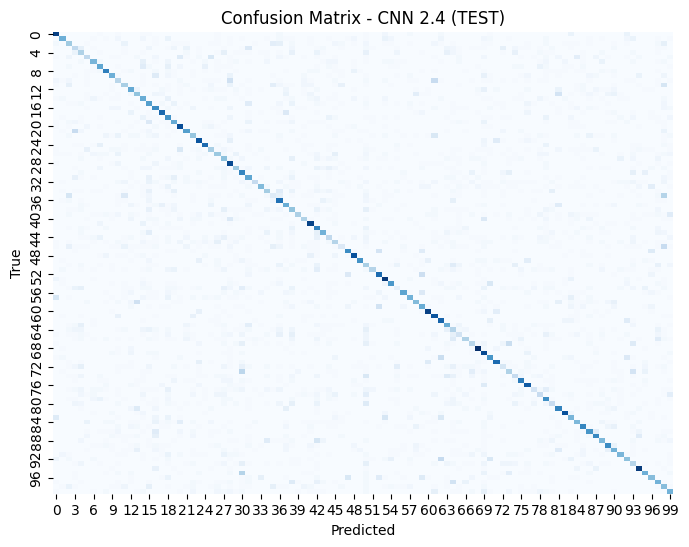

In [85]:
# Evaluation of CNN model
modelCNN24.eval()

allPreds = []
allLabels = []
allLoss = []

criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in testLoaderAug:   # TEST SET (AUGMENTED)
        images = images.to(device)
        labels = labels.to(device)

        outputs = modelCNN24(images)
        loss = criterion(outputs, labels)

        preds = torch.argmax(outputs, dim=1)

        allPreds.extend(preds.cpu().numpy())
        allLabels.extend(labels.cpu().numpy())
        allLoss.append(loss.item())

accuracy = accuracy_score(allLabels, allPreds)
f1 = f1_score(allLabels, allPreds, average="macro")
precision = precision_score(allLabels, allPreds, average="macro")
recall = recall_score(allLabels, allPreds, average="macro")

print("CNN 2.4 Evaluation (TEST - AUGMENTED)")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 macro : {f1:.4f}")
print(f"Precision macro : {precision:.4f}")
print(f"Recall macro : {recall:.4f}")
print(f"Mean test loss : {np.mean(allLoss):.4f}")

cm = confusion_matrix(allLabels, allPreds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("Confusion Matrix - CNN 2.4 (TEST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


The results of the CNN 2.4 model show that the network is able to learn basic visual patterns, as illustrated by the visible diagonal in the confusion matrix. However, the performance remains limited, with an accuracy slightly above 40%. This indicates strong confusion between classes, which is expected given the large number of categories in CIFAR-100 and the simplicity of the model. Even with data augmentation and normalization, the CNN reaches a clear performance ceiling. These results highlight the limitations of training a standard CNN from scratch on a fine-grained classification task and motivate the use of more advanced architectures.

ResNet 7.2 Evaluation (TEST - RAW)
Accuracy : 0.4276
F1 macro : 0.4220
Precision macro : 0.4346
Recall macro : 0.4276
Mean test loss : 2.4274


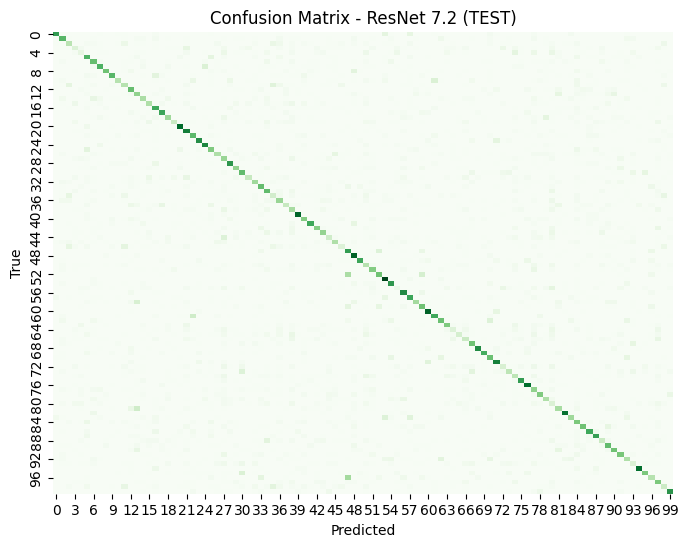

In [86]:
# Evaluation of Resnet model
resnetModel.eval()

allPreds = []
allLabels = []
allLoss = []

criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in rawTestLoader:   # TEST SET (RAW)
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnetModel(images)
        loss = criterion(outputs, labels)

        preds = torch.argmax(outputs, dim=1)

        allPreds.extend(preds.cpu().numpy())
        allLabels.extend(labels.cpu().numpy())
        allLoss.append(loss.item())

accuracy = accuracy_score(allLabels, allPreds)
f1 = f1_score(allLabels, allPreds, average="macro")
precision = precision_score(allLabels, allPreds, average="macro")
recall = recall_score(allLabels, allPreds, average="macro")

print("ResNet 7.2 Evaluation (TEST - RAW)")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 macro : {f1:.4f}")
print(f"Precision macro : {precision:.4f}")
print(f"Recall macro : {recall:.4f}")
print(f"Mean test loss : {np.mean(allLoss):.4f}")

cm = confusion_matrix(allLabels, allPreds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="Greens", cbar=False)
plt.title("Confusion Matrix - ResNet 7.2 (TEST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


The ResNet 7.2 model achieves slightly better results than the baseline CNN, with an accuracy close to 43%. The confusion matrix shows a clearer and more consistent diagonal, which indicates that the model is able to better separate the different classes. This improvement can be explained by the residual connections, which help the network learn deeper and more stable representations. However, despite this progress, the model still struggles with fine-grained distinctions between visually similar classes, which remains a key difficulty of the CIFAR-100 dataset. Overall, ResNet 7.2 provides a noticeable but limited improvement compared to a standard CNN.

Ensemble 7.7.3 Evaluation (TEST - RAW)
Accuracy : 0.4130
F1 macro : 0.4064
Precision macro : 0.4292
Recall macro : 0.4130


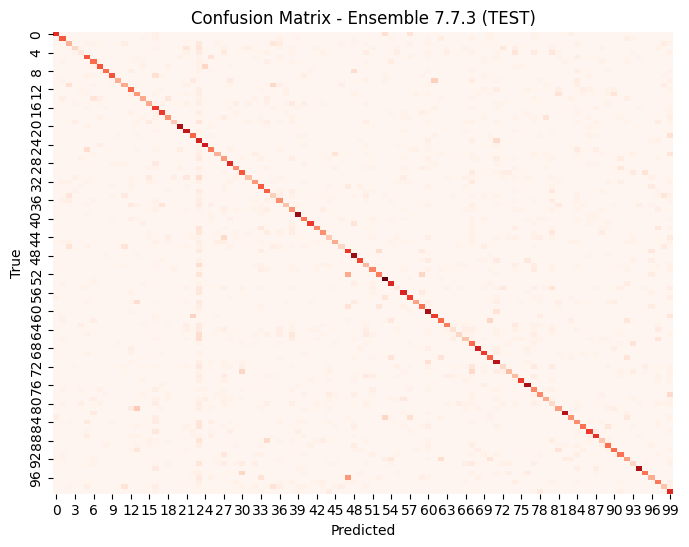

In [87]:
# Evaluation of ensemble model
resnetModel.eval()
efficientNetModel.eval()

allPreds = []
allLabels = []

with torch.no_grad():
    for images, labels in rawTestLoader:   # TEST SET (RAW)
        images = images.to(device)
        labels = labels.to(device)

        outRes = resnetModel(images)
        outEff = efficientNetModel(images)

        probsRes = F.softmax(outRes, dim=1)
        probsEff = F.softmax(outEff, dim=1)

        avgProbs = (probsRes + probsEff) / 2
        preds = torch.argmax(avgProbs, dim=1)

        allPreds.extend(preds.cpu().numpy())
        allLabels.extend(labels.cpu().numpy())

accuracy = accuracy_score(allLabels, allPreds)
f1 = f1_score(allLabels, allPreds, average="macro")
precision = precision_score(allLabels, allPreds, average="macro")
recall = recall_score(allLabels, allPreds, average="macro")

print("Ensemble 7.7.3 Evaluation (TEST - RAW)")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 macro : {f1:.4f}")
print(f"Precision macro : {precision:.4f}")
print(f"Recall macro : {recall:.4f}")

cm = confusion_matrix(allLabels, allPreds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="Reds", cbar=False)
plt.title("Confusion Matrix - Ensemble 7.7.3 (TEST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


The ensemble model showed a much higher accuracy on the validation set than on the test set, while the individual models remained stable. This suggests that the ensemble benefited from a favorable alignment of predictions on the validation data. On the test set, the two models tend to make similar mistakes, which limits the effectiveness of soft voting. As a result, the ensemble does not generalize better than the individual models.

## 8.3 Comparison on the test set

| Model                | Test Data Type            | Accuracy | F1 Macro | Precision Macro | Recall Macro | Mean Test Loss |
|----------------------|---------------------------|----------|----------|------------------|--------------|----------------|
| CNN 2.4              | Augmented & Normalized    | 0.4114   | 0.4062   | 0.4261           | 0.4114       | 2.2437         |
| ResNet 7.2           | RAW                       | 0.4276   | 0.4220   | 0.4346           | 0.4276       | 2.4274         |
| Ensemble 7.7.3       | RAW                       | 0.4130   | 0.4064   | 0.4292           | 0.4130       | –              |


Based on the test set evaluations, all three models achieve similar performance levels, with accuracies ranging from around 41% to 43%. The baseline CNN 2.4 shows stable but limited results, confirming that a standard CNN trained from scratch struggles on a complex dataset like CIFAR-100. ResNet 7.2 achieves the best overall performance, highlighting the benefit of residual connections and deeper feature representations. The ensemble model does not outperform ResNet 7.2, suggesting that combining models trained on similar data does not necessarily improve generalization. Overall, these results show that architectural improvements have a stronger impact than model ensembling in this context.

## 8.4 Limitations

The main limitation of this project is the difficulty of the CIFAR-100 dataset itself. With 100 fine-grained classes and low-resolution images (32×32), many classes are visually very similar, which leads to strong inter-class confusion. This makes it hard for relatively small models to learn highly discriminative features.


Another limitation comes from the architectures used. The custom CNN models, even when improved and regularized, quickly reach a 
performance ceiling. This shows us that increasing depth alone is not sufficient for such a complex task.


Regarding the ensemble model, its performance is limited by the lack of diversity between the combined models. Since both models were trained on similar RAW representations, their errors are often correlated, which reduces the benefit of soft voting.


Finally, training time and computational resources constrained the number of experiments, epochs, and hyperparameter tuning that could be explored.

## 8.5 Future improvements

Some improvements could be explored in future work. First, using, even deeper ResNet variants or Vision Transformers adapted to small images, could improve feature representation. But we have to keep in mind that the deeper the longer it takes and it is exponential.


Second, better ensemble strategies could be investigated, such as combining more diverse models, using weighted voting, or 
stacking.


Third, different data augmentation techniques (such as CutMix or MixUp) and learning rate schedules could help improve generalization without overfitting.


Finally, a more systematic hyperparameter optimization and longer training could further improve performance, especially for transfer learning models.

## 8.6 Conclusion

In this project, we compared several convolutional models on the CIFAR-100 dataset. The results show that training a standard CNN from scratch leads to limited performance, even when data augmentation is applied. Using a deeper architecture with residual connections improves results and allows the model to learn more discriminative features. Among all models, ResNet 7.2 achieves the best overall performance on the test set.


The ensemble approach did not provide additional improvements, mainly because the combined models make similar mistakes on unseen data. This highlights that ensembling is only effective when models are sufficiently diverse. Overall, these experiments confirm that architectural choices play a more important role than data augmentation or simple ensembling for fine-grained image classification on CIFAR-100.

Even if our model does not reach perfect accuracy, its performance is already sufficient to imagine a first version of an educational toy. For a simple and affordable product, recognizing common objects and animals can already create curiosity and encourage children to interact with their environment. For a more premium version of the toy, the model could be further trained and improved to achieve higher accuracy and handle more complex situations. Our hope is that this kind of playful technology can help children spend less time on screens and more time discovering the world around them.